In [14]:
from libpysal.weights import Queen
import libpysal as lp

In [15]:
import pysal

TypeError: Passing a dict as an indexer is not supported. Use a list instead.

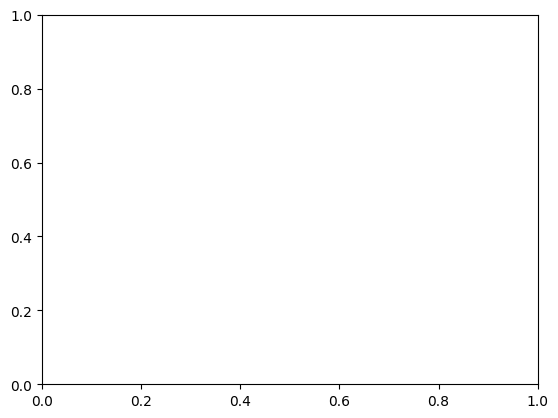

In [16]:
from libpysal.weights import Queen
import libpysal as lp
import geopandas
gdf = geopandas.read_file(lp.examples.get_path("columbus.shp"))
weights = Queen.from_dataframe(gdf)
tmp = weights.plot(gdf, color='firebrickred', node_kws=dict(marker='*', color='k'))

In [1]:
from spint.gravity import  BaseGravity, Gravity, Production, Attraction, Doubly
from spint.dispersion import phi_disp
from spint.vec_SA import VecMoran
import pysal as ps
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
from descartes import PolygonPatch
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap  # pip install basemap --user
import pyproj as pj
from shapely.geometry import Polygon, Point

#Load NYC bike data - trips between census tract centroids
bikes = pd.read_csv(r'D:\datasets\nyc_bikes_ct.csv')
#Remove intrazonal flows
bikes = bikes[bikes['o_tract'] != bikes['d_tract']]
bikes.loc[bikes.o_sq_foot == 0, 'o_sq_foot'] = 1
bikes.loc[bikes.d_sq_foot == 0, 'd_sq_foot'] = 1
bikes.loc[bikes.o_cap == 0, 'o_cap'] = 1
bikes.loc[bikes.d_cap == 0, 'd_cap'] = 1
bikes.loc[bikes.o_housing == 0, 'o_housing'] = 1
bikes.loc[bikes.d_housing == 0, 'd_housing'] = 1
#Flows between tracts
flows = bikes['count'].values.reshape((-1,1))
#Origin variables: square footage of buildings, housing units, total station capacity
o_vars = np.hstack([bikes['o_sq_foot'].values.reshape((-1,1)),
                    bikes['o_housing'].values.reshape((-1,1)),
                    bikes['o_cap'].values.reshape((-1,1))])

#Destination variables: square footage of buildings, housing units, total station capacity
d_vars = np.hstack([bikes['d_sq_foot'].values.reshape((-1,1)),
                    bikes['d_housing'].values.reshape((-1,1)),
                    bikes['d_cap'].values.reshape((-1,1))])
#Trip "cost" in time (seconds)
cost = bikes['tripduration'].values.reshape((-1,1))
#Origin ids
o = bikes['o_tract'].astype(str).values.reshape((-1,1))

#destination ids
d = bikes['d_tract'].astype(str).values.reshape((-1,1))

C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\libpysal\cg\alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\libpysal\cg\alpha_shapes.py:198: Nu

In [19]:
flows

array([[5709],
       [4010],
       [1906],
       ...,
       [ 348],
       [ 463],
       [5025]], dtype=int64)

In [2]:
from spint.gravity import  BaseGravity, Gravity, Production, Attraction, Doubly
from spint.dispersion import phi_disp
from spint.vec_SA import VecMoran
import pysal as ps
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
from descartes import PolygonPatch
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap  # pip install basemap --user
import pyproj as pj
from shapely.geometry import Polygon, Point

#Load NYC bike data - trips between census tract centroids
bikes = pd.read_csv(r'D:\datasets\nyc_bikes_ct.csv')
#Remove intrazonal flows
bikes = bikes[bikes['o_tract'] != bikes['d_tract']]
bikes.loc[bikes.o_sq_foot == 0, 'o_sq_foot'] = 1
bikes.loc[bikes.d_sq_foot == 0, 'd_sq_foot'] = 1
bikes.loc[bikes.o_cap == 0, 'o_cap'] = 1
bikes.loc[bikes.d_cap == 0, 'd_cap'] = 1
bikes.loc[bikes.o_housing == 0, 'o_housing'] = 1
bikes.loc[bikes.d_housing == 0, 'd_housing'] = 1
#Flows between tracts
flows = bikes['count'].values.reshape((-1,1))
#Origin variables: square footage of buildings, housing units, total station capacity
o_vars = np.hstack([bikes['o_sq_foot'].values.reshape((-1,1)),
                    bikes['o_housing'].values.reshape((-1,1)),
                    bikes['o_cap'].values.reshape((-1,1))])

#Destination variables: square footage of buildings, housing units, total station capacity
d_vars = np.hstack([bikes['d_sq_foot'].values.reshape((-1,1)),
                    bikes['d_housing'].values.reshape((-1,1)),
                    bikes['d_cap'].values.reshape((-1,1))])
#Trip "cost" in time (seconds)
cost = bikes['tripduration'].values.reshape((-1,1))
#Origin ids
o = bikes['o_tract'].astype(str).values.reshape((-1,1))

#destination ids
d = bikes['d_tract'].astype(str).values.reshape((-1,1))

grav= Gravity(flows, o_vars, d_vars, cost, 'exp')
print (grav.params)
print ('Adjusted psuedo R2: ', grav.adj_pseudoR2)
print ('Adjusted D2: ', grav.adj_D2)
print ('SRMSE: ', grav.SRMSE)
print ('Sorensen similarity index: ', grav.SSI)

#Next we fit a production-constrained model

prod = Production(flows, o, d_vars, cost, 'exp')

print (prod.params[-4:]) #truncate to exclude balancing factors/fixed effects

print ('Adjusted psuedo R2: ', prod.adj_pseudoR2)
print ('Adjusted D2: ', prod.adj_D2)
print ('SRMSE: ', prod.SRMSE)
print ('Sorensen similarity index: ', prod.SSI)

att = Attraction(flows, d, o_vars, cost, 'exp')
print (att.params[-4:]) #truncate to exclude balancing factors/fixed effects

print ('Adjusted psuedo R2: ', att.adj_pseudoR2)
print ('Adjusted D2: ', att.adj_D2)
print ('SRMSE: ', att.SRMSE)
print ('Sorensen similarity index: ', att.SSI)

#Finally, we fit the doubly constrained model

doub = Doubly(flows, o, d, cost, 'exp')

print (doub.params[-1:]) #truncate to exclude balancing factors/fixed effects

print ('Adjusted psuedo R2: ', doub.adj_pseudoR2)
print ('Adjusted D2: ', doub.adj_D2)
print ('SRMSE: ', doub.SRMSE)
print ('Sorensen similarity index: ', doub.SSI)

print (phi_disp(grav))
print (phi_disp(prod))
print (phi_disp(att))
print (phi_disp(doub))

print ('Production-constrained Poisson model standard errors and tvalues')
print (prod.params[-4:])
print (prod.std_err[-4:])
print (prod.tvalues[-4:])

#Fit the same model using QuasiPoisson framework
Quasi = Production(flows, o, d_vars, cost, 'exp', Quasi=True)

print ('Production-constrained QuasiPoisson model standard errors and tvalues')
print (Quasi.params[-4:])
print (Quasi.std_err[-4:])
print (Quasi.tvalues[-4:])


local_prod = prod.local()
print(local_prod.keys())

#Prep OD data as vectors and then compute origin or destination focused distance-based weights

ids = bikes['index'].values.reshape((-1,1))
origin_x = bikes['SX'].values.reshape((-1,1))
origin_y = bikes['SY'].values.reshape((-1,1))
dest_x = bikes['EX'].values.reshape((-1,1))
dest_y = bikes['EY'].values.reshape((-1,1))


import libpysal
vecs = np.hstack([ids, origin_x, origin_y, dest_x, dest_y])
origins = vecs[:,1:3]
wo = libpysal.weights.DistanceBand(origins, 999, alpha=-1.5, binary=False, build_sp=False, )
dests = vecs[:,3:5]
wd =libpysal.weights.DistanceBand(dests, 999, alpha=-1.5, binary=False, build_sp=False,)
vmo = VecMoran(vecs, wo, permutations=1)
print(vmo.I)
vmd = VecMoran(vecs, wd, permutations=1)
print(vmd.I)

[ 1.28790485  0.06902469  0.04276277  0.50930082  0.03932893  0.04896158
  0.39933316 -0.00227255]
Adjusted psuedo R2:  0.7733814647428341
Adjusted D2:  0.778812957963239
SRMSE:  0.9164109658985744
Sorensen similarity index:  0.7452183304993184
[ 0.00437122  0.06794379  0.85720958 -0.00227555]
Adjusted psuedo R2:  0.8323996326918957
Adjusted D2:  0.8369632138846004
SRMSE:  0.7939386367113797
Sorensen similarity index:  0.7779653611213762
[ 0.05281568  0.05689814  0.85161213 -0.00229343]
Adjusted psuedo R2:  0.8325284446300052
Adjusted D2:  0.837094085859849
SRMSE:  0.7923955894283944
Sorensen similarity index:  0.7775574816344923
[-0.00232112]
Adjusted psuedo R2:  0.8955759665826606
Adjusted D2:  0.9003422192806175
SRMSE:  0.6278160230289607
Sorensen similarity index:  0.8182940764548702
[3.00106525e+002 2.35343616e+001 9.07642846e-123]
[2.06092255e+002 2.60328203e+001 1.05289600e-149]
[2.07645243e+002 2.64229678e+001 3.73180683e-154]
[1.18261248e+002 2.96580921e+001 1.33362721e-193]
P

C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\scipy\spatial\_kdtree.py:60: RuntimeWarning: invalid value encountered in subtract
  return np.sum(np.abs(y-x)**p, axis=-1)
C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\spint\vec_SA.py:244: RuntimeWarning: invalid value encountered in subtract
  u = (self.y[:, 3] - self.y[:, 1]) - (xDbar - xObar)
C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\spint\vec_SA.py:244: RuntimeWarning: invalid value encountered in scalar subtract
  u = (self.y[:, 3] - self.y[:, 1]) - (xDbar - xObar)
C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\spint\vec_SA.py:245: RuntimeWarning: invalid value encountered in subtract
  v = (self.y[:, 4] - self.y[:, 2]) - (yDbar - yObar)
C:\Users\richie\anaconda3\envs\usda\Lib\site-packages\spint

nan
nan


In [ ]:
#Read in census tracts for NYC
crs = {'datum':'WGS84', 'proj':'longlat'}
tracts =r'D:\datasets\nyc_bikes\nyct2010.shp'
tracts = gp.read_file(tracts)
tracts = tracts.to_crs(crs=crs)

#subset manhattan tracts
man_tracts = tracts[tracts['BoroCode'] == '1'].copy()
man_tracts['CT2010S'] = man_tracts['CT2010'].astype(int).astype(str)

#Get tracts for which there are no onbservations
mt = set(man_tracts.CT2010S.unique())
lt = set(np.unique(o))
nt = list(mt.difference(lt))
no_tracts = pd.DataFrame({'no_tract':nt})
no_tracts = man_tracts[man_tracts.CT2010S.isin(nt)].copy()


#Join local values to census tracts
local_vals = pd.DataFrame({'betas': local_prod['param3'], 'tract':np.unique(o)})
local_vals = pd.merge(local_vals, man_tracts[['CT2010S', 'geometry']], left_on='tract', right_on='CT2010S')
local_vals = gp.GeoDataFrame(local_vals)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
local_vals['inv_betas'] = (local_vals['betas']*-1)
no_tracts['test'] = 0
no_tracts.plot('test', cmap='copper', ax=ax)
local_vals.plot('inv_betas', cmap='Blues', ax=ax)
plt.xlim(-74.02, -73.95)
plt.ylim(40.7, 40.78)




In [3]:
bikes.loc[0]

Unnamed: 0                             0
index                                  0
count                               5709
d_cap                              255.0
d_tract                              600
distance                             NaN
end station latitude           40.712899
end station longitude         -73.989865
o_cap                              162.0
o_tract                              202
start station latitude          40.71318
start station longitude        -73.98189
tripduration                  474.173605
o_pop                               8012
d_pop                              11558
o_housing                           3598
d_housing                           4083
tract_x                              202
o_sq_foot                  37878157.9781
tract_y                              600
d_sq_foot                  59149181.7526
tract                              600.0
diffs_out                     28553756.0
start                                202
end             

In [ ]:
#------------------------
def tij(alpha,lamb,beta,pi,pj,d,k=1e-5):
    tij=k*(pi**alpha*pj**lamb)/d**beta
    print(tij)


---

In [1]:
import skgstat as skg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
skg.plotting.backend('matplotlib')

In [2]:
s = [30, 80, 300]
data1 = skg.data.pancake(N=s[0], seed=42, as_dataframe=True).get('sample')
data2 = skg.data.pancake(N=s[1], seed=42, as_dataframe=True).get('sample')
data3 = skg.data.pancake(N=s[2], seed=42, as_dataframe=True).get('sample')

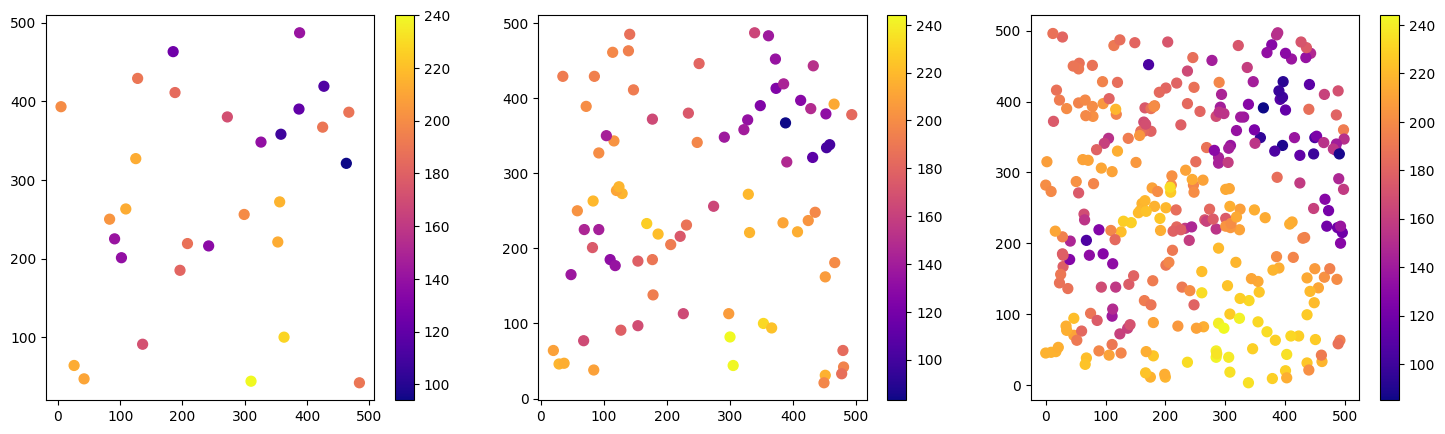

In [3]:
def plot_scatter(data, ax):
    art = ax.scatter(data.x, data.y, 50, c=data.v, cmap='plasma')
    plt.colorbar(art, ax=ax)

# run
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for data, ax in zip((data1, data2, data3), axes.flatten()):
    plot_scatter(data, ax)

In [4]:
data1.shape

(30, 3)

In [5]:
data1

,x,y,v
0,463,321,94
1,109,263,213
2,242,216,136
3,128,429,190
4,310,44,240
5,42,47,210
6,136,91,172
7,188,411,185
8,5,393,200
9,326,348,139


In [6]:
np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, 3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]
time = pd.date_range("2014-09-06", periods=3)
reference_time = pd.Timestamp("2014-09-05")

In [8]:
temperature.shape

(2, 2, 3)

AttributeError: 'list' object has no attribute 'shape'

In [10]:
LC.data.shape

NameError: name 'LC' is not defined

---

In [2]:
from osgeo import gdal, ogr, osr # python -m pip install path-to-wheel-file.whl; https://www.lfd.uci.edu/~gohlke/pythonlibs/ (GDAL-3.4.3-cp311-cp311-win_amd64.whl;GDAL-3.4.3-cp310-cp310-win_amd64.whl)

In [3]:
import pyproj

In [4]:
pyproj.__version__

'3.6.0'

In [7]:
import timm

In [197]:
from libpysal.weights.spintW import ODW

In [31]:
land_use_inventory_2018_fn=r'D:\datasets\Land_Use_Inventory_for_Northeastern_Illinois%2C_2018.geojson'
LU=gpd.read_file(land_use_inventory_2018_fn)

In [ ]:
chicago_boundary_fn=r'D:\datasets\scale\Boundaries - City.geojson'
chicago_boundary_gdf=gpd.read_file(chicago_boundary_fn)
chicago_boundary_gdf.to_crs(LU.crs,inplace=True)
LU_chicago=gpd.clip(LU,chicago_boundary_gdf)
LU_chicago_fn=r'D:\datasets\Land_Use_Inventory_2018_chicago.GeoJSON'
LU_chicago.to_file(LU_chicago_fn,driver='GeoJSON')

In [183]:
from libpysal.weights import Voronoi
points= np.random.random((5,2))*10 + 10
w1 = Voronoi(points)

points2= np.random.random((5,2))*10 + 10
w2 = Voronoi(points2)

In [203]:
points

array([[17.00020236, 16.32804384],
       [15.16382077, 14.2490127 ],
       [13.67523175, 17.0256166 ],
       [12.72011724, 14.07577023],
       [10.91615612, 18.94363486]])

In [204]:
points2

array([[13.07300407, 16.28688616],
       [14.06452829, 17.66305048],
       [17.77812311, 11.23479208],
       [15.81847814, 11.02293657],
       [10.29602511, 10.93944145]])

In [184]:
w1.weights

{0: [1.0, 1.0],
 1: [1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0],
 4: [1.0]}

In [186]:
w2.weights

{0: [1.0, 1.0, 1.0], 1: [1.0], 2: [1.0], 3: [1.0, 1.0, 1.0], 4: [1.0, 1.0]}

In [187]:
w2.neighbors

{0: [1, 3, 4], 1: [0], 2: [3], 3: [0, 2, 4], 4: [0, 3]}

In [191]:
OD = libpysal.weights.ODW(w1,w2)

In [206]:
OD.full()[0].shape

(25, 25)

In [192]:
OD.neighbors

{0: [6, 8, 9, 11, 13, 14],
 1: [5, 10],
 2: [8, 13],
 3: [5, 7, 9, 10, 12, 14],
 4: [5, 8, 10, 13],
 5: [1, 3, 4, 11, 13, 14, 16, 18, 19],
 6: [0, 10, 15],
 7: [3, 13, 18],
 8: [0, 2, 4, 10, 12, 14, 15, 17, 19],
 9: [0, 3, 10, 13, 15, 18],
 10: [1, 3, 4, 6, 8, 9, 16, 18, 19, 21, 23, 24],
 11: [0, 5, 15, 20],
 12: [3, 8, 18, 23],
 13: [0, 2, 4, 5, 7, 9, 15, 17, 19, 20, 22, 24],
 14: [0, 3, 5, 8, 15, 18, 20, 23],
 15: [6, 8, 9, 11, 13, 14],
 16: [5, 10],
 17: [8, 13],
 18: [5, 7, 9, 10, 12, 14],
 19: [5, 8, 10, 13],
 20: [11, 13, 14],
 21: [10],
 22: [13],
 23: [10, 12, 14],
 24: [10, 13]}

In [193]:
OD.weights

{0: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 1: [0.5, 0.5],
 2: [0.5, 0.5],
 3: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 4: [0.25, 0.25, 0.25, 0.25],
 5: [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 6: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 7: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 8: [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 9: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,


In [202]:
16**2

256

In [323]:
import math
deg2meter=lambda degree:degree*(2 * math.pi * 6378137.0)/ 360
meter2deg=lambda meter:meter/(2 * math.pi * 6378137.0) * 360

In [5]:
%load_ext autoreload 
%autoreload 2
import usda.geodata_process as usda_geodataProcess

import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from rasterio.plot import show
import shapely
import geopandas as gpd
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


读取 LC 栅格元数据，用其投影（CRS）信息变换样方左下角和右上角的经纬度坐标。

In [119]:
seg_merged_fn=r'D:\datasets\cook_seg_merged.tif'   
LC=rxr.open_rasterio(seg_merged_fn)
grain_size=[round(i,3) for i in LC.rio.resolution()]
print(f'grain size (cell size)={grain_size}',)
LC

grain size (cell size)=[0.6, -0.6]


<xarray.DataArray (band: 1, y: 140841, x: 113056)>
[15922920096 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.909e+05 3.909e+05 ... 4.588e+05 4.588e+05
  * y            (y) float64 4.672e+06 4.672e+06 ... 4.587e+06 4.587e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        6
    STATISTICS_MEAN:           2.5892105975183
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         2.3036488073343
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

In [120]:
LC.rio.crs

CRS.from_epsg(26916)

In [329]:
LC.x.values.shape

(113056,)

In [363]:
LC_clipped= LC.rio.clip_box(
    minx=LC.x.values[50000],
    miny=LC.y.values[-50000],
    maxx=LC.x.values[50000]+5000,
    maxy=LC.y.values[-50000]+5000,
    crs=LC.rio.crs,
    )

In [364]:
LC_clipped_downsampled=usda_geodataProcess.upNdownsampling(LC_clipped,1/40)  

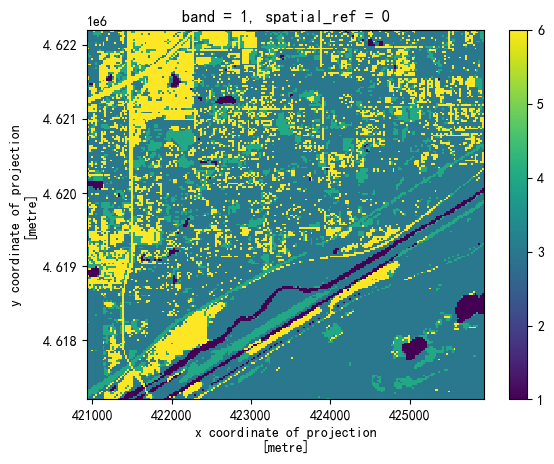

In [365]:
LC_clipped_downsampled.plot();

In [366]:
LC_clipped_downsampled

<xarray.DataArray (band: 1, y: 208, x: 208)>
array([[[3, 3, 3, ..., 3, 4, 4],
        [3, 3, 3, ..., 3, 4, 4],
        [3, 3, 3, ..., 3, 4, 4],
        ...,
        [4, 4, 3, ..., 3, 3, 3],
        [4, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]]], dtype=uint8)
Coordinates:
  * x            (x) float64 4.209e+05 4.21e+05 4.21e+05 ... 4.259e+05 4.259e+05
  * y            (y) float64 4.622e+06 4.622e+06 ... 4.617e+06 4.617e+06
  * band         (band) int32 1
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        6
    STATISTICS_MEAN:           2.5870012262799
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         2.3042352364215
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                255

In [7]:
seg_merged_fn=r'D:\datasets\cook_seg_merged.tif'   
LC=rxr.open_rasterio(seg_merged_fn)
grain_size=[round(i,3) for i in LC.rio.resolution()]
print(f'grain size (cell size)={grain_size}',)
LC

grain size (cell size)=[0.6, -0.6]


<xarray.DataArray (band: 1, y: 140841, x: 113056)>
[15922920096 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.909e+05 3.909e+05 ... 4.588e+05 4.588e+05
  * y            (y) float64 4.672e+06 4.672e+06 ... 4.587e+06 4.587e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        6
    STATISTICS_MEAN:           2.5870012262799
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         2.3042352364215
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

在幅度变化上，选择了100、500、1000和1500等 4 个连续大小变化的样方。所有幅度固定样方左下角位置坐标，仅通过变化右上角坐标调整样方大小。通过各个样方，用定义的`rio_read_subset()`方法读取对应样方的 LC 栅格数据，返回的值有 LC 栅格值数组`LC`，变换信息`transform`，元数据`ras_meta`等，其中变换信息用于后续地图打印、[xarray](https://docs.xarray.dev/en/stable/)或[rioxarray](https://corteva.github.io/rioxarray/stable/)库中[DataArray](https://docs.xarray.dev/en/stable/user-guide/data-structures.html)格式数据重建。

In [12]:
pt_leftBottom=[-87.840427, 41.876229]
pt_leftBottom_pj=usda_geodataProcess.pt_coordi_transform(4326,LC.rio.crs,pt_leftBottom)
ws=[100,500,1000,1500]
pt_rightTop_pj_lst=[]
for w in ws:    
    pt_rightTop_pj=[i+w for i in pt_leftBottom_pj] 
    pt_rightTop_pj_lst.append(pt_rightTop_pj)

In [88]:
LC_extents=[]
for pt_rightTop_pj in tqdm(pt_rightTop_pj_lst):
    LC_part,transform,ras_meta=usda_geodataProcess.rio_read_subset(seg_merged_fn,[pt_leftBottom_pj,pt_rightTop_pj])  
    LC_part_info={'coordi':[pt_leftBottom_pj,pt_rightTop_pj],'LC':LC_part,'transform':transform,'ras_meta':ras_meta}  
    LC_extents.append(LC_part_info)

100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.83it/s]


为了打印 LC 地图时，在后一较大幅度地图中对应打印前一较小幅度边界，观察幅度对位关系，需要根据左下角和右上角坐标构建样方的几何矩形，并定义为`GeoDataFrame`格式数据。

In [13]:
extend_shp_lst=[]
for pt_rightTop_pj in pt_rightTop_pj_lst:
    extend_shp_lst.append(shapely.box(*pt_leftBottom_pj,*pt_rightTop_pj))
extend_df=pd.DataFrame({'geometry':extend_shp_lst})
extend_gdf=gpd.GeoDataFrame(extend_df,geometry='geometry',crs=LC.rio.crs)

In [11]:
zip_pop_controid_gdf['pop_id']=zip_pop_controid_gdf.apply(lambda row:f'pop_{row.name}',axis=1)
park_boundaries_centroid_gdf['park_id']=park_boundaries_centroid_gdf.apply(lambda row:f'park_{row.name}',axis=1)